# STINTSY Machine Project
#### *Members: Chua, Raynier, Ocampo, Andrea Nicole, Tan, Alison Chloe*

In this notebook, we will be using the dataset "Sentiment Analysis of IMDB Movie Reviews" published in Kaggle by Lakshimipathi N. The dataset can be accessed through this link: https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/notebook.

## Import
First, import the dependencies needed for this notebook. We will be making use of numpy, pandas, matplotlib, torch, scikit-learn, and nltk to assist us in our analysis. We also install some nltk packages to assist in cleaning the dataset later.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sklearn
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')  # Package for Stop word removal
nltk.download('wordnet') # Package for Lemmatizer
nltk.download('omw-1.4') # Package for Lemmatizer
nltk.download('averaged_perceptron_tagger') # Package for Lemmatizer
nltk.download('punkt')  # Package for Tokenization
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tanal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tanal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tanal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tanal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-d

True

## The Dataset
The Sentiment Analysis dataset contains 50,000 highly polar movie reviews taken from IMDB. It contains two variables (columns): `review` and `sentiment`.

`review` contains unedited, likely raw and datamined, reviews for movies which may contain HTML tags. For this dataset, the movie rating and review title have not been included.

`sentiment` contains the sentiment label given to the review. Unlike many popular sentiment analysis datasets, this dataset does not consider 'neutral' reviews. Thus, the sentiment label can only take one of two values: positive or negative. However, this should not be a significant issue since the dataset contains highly polar movie reviews.

## Reading the Dataset
Our first step is loading the dataset into a pandas `DataFrame`. To do this, we use the `read_csv` function. Note that the path contained within the parentheses may change depending on the location of the file in the machine.

In [2]:
path = 'IMDB_Dataset.csv'
df_imdb =  pd.read_csv(path)

Next, we display the general information about the dataset.

In [3]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


As shown here, there are 50,000 rows of data. Let us also take a look at the first few rows of the dataset.

In [4]:
df_imdb.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


From the first 10 rows, it can be seen that there are still leftover HTML tags (likely from datamining) as well as some spelling and grammatical errors. In the next part, we will attempt to clean the dataset to reduce the impact of these errors on the analysis.

## Cleaning the Dataset
Before we proceed with exploring our dataset, we must clean it first to prevent any inconsistencies from arising during the analysis. This dataset still contains a lot of strings that are unnecessary or do not add to the meaning of the review. To clean this data, we take inspiration from various other cleaning methods and apply the steps listed below in the specified order:
- Remove duplicates
- Remove HTML strips
- Transform to lowercase
- Remove URLs and special characters
- Remove stop words
- Apply lemmatization

Previously, we had experimented with the order in which these steps occurred and noticed that certain words that do not add to the meaning were still being left behind. Thus, we reordered these steps multiple times until we determined that it was removing the unnecessary words satisfactorily.

### Check for Duplicate Data
Little information has been provided on how the data in this dataset was gathered. Thus, depending on the method of data gathering, some duplicates might arise which could impact the analysis. Since there is a lot of data, we first take a look at the overview to check for any duplicates.

In [5]:
df_imdb.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


As shown above, there are 50,000 rows but only 49,582 unique values. Before we remove the duplicates, we will take a look at them below.

In [6]:
df_imdb[df_imdb.duplicated(keep=False)]

,review,sentiment
42,"Of all the films I have seen, this one, The Ra...",negative
84,"We brought this film as a joke for a friend, a...",negative
140,"Before I begin, let me get something off my ch...",negative
219,Ed Wood rides again. The fact that this movie ...,negative
245,I have seen this film at least 100 times and I...,positive
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


Since the reviews are long, they are unlikely to have been written by different users. Thus, some data might have been duplicated due to the data gathering method or due to the user (accidentally) submitting the same review multiple times. Regardless, the duplicate data will be removed in order to speed up the process of the next steps of cleaning.

In [7]:
df_imdb = df_imdb.drop_duplicates()

We again check to see if the duplicates have been successfully removed.

In [8]:
df_imdb.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


### Remove HTML strips
Earlier, it was mentioned that there are still some leftover HTML tags. Since these do not add any meaning to the reviews, these will be removed. We display the results of processing for a single row below.

In [9]:
df_imdb.iloc[0]['review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Since HTML tags are encased in angle brackets <>, we run the following code to strip the column of HTML tags using regular expression. Because we are relying on angle brackets to find the tags, these must be removed before the punctuation marks and other special characters are removed.

In [10]:
df_imdb['review'] = df_imdb['review'].str.replace(r'<[^<>]*>', '', regex=True)

As can be seen from the selected sample, the HTML tags have now been removed. The same effect can be seen in the succeeding instances.

In [11]:
df_imdb.iloc[0]['review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

### Transform to lowercase
Since words can be represented differently (e.g. 'Chair' and 'chair'), we transform the reviews to lowercase to prevent adding unnecessary dimensions to the vector space during modelling. 

In [12]:
df_imdb['review'] = df_imdb['review'].str.lower()

In [13]:
df_imdb['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 49582, dtype: object

### Remove URLs and special characters
We remove any URLs and some special characters, including punctuations and emojis, in the reviews. We display its effects on a random sample and a sample from the dataset that was observed to contain a URL. Initially, the URLs and special characters were removed separately using different regex operations. The URLs were removed first, followed by the special characters. However, we noticed that they could be combined into one step. This step was placed before the removal of stopwords for various reasons.

First, although the list of stopwords provided by nltk is very diverse, it is unable to remove these words when they are beside punctuation marks. Previously, we had encountered problems where stopwords in the list were not removed because they were placed beside periods and other punctuation marks as shown below:
- I like the **movie.I** also like the actors...
- **Here,** the basic structure of part one...
These kept them from being removed at the end.

Second, the list of stopwords included multiple representations of the same word, especially when it comes to contractions. For example, `you'll`, `you`, and `ll` were all included in the list. Removing the punctuation marks now enabled us to shrink the list of stopwords and speed up the process of cleaning.

In [14]:
idx = np.random.randint(0, len(df_imdb))
print(df_imdb.iloc[idx]['review'])
print(df_imdb.iloc[907]['review'])

i was sooooo excited to see this movie after finally reading the book this week. my 13 year old son was looking forward to it too. i rented it and snuggled down to enjoy a classic holiday story brought to life on screen.boy, was i disappointed. this movie veered off from the book more times than is forgivable. george c. scott is an excellent actor but in this, it seemed that he was fully into character only about 20% of the time. the rest of the time he was quite flat.i realize that this was made in '84, pre-cg effects, for the most part. but it looked to be very b-movie quality, especially the encounter with jacob marley.the biggest disappointment was the fact that they left out one of the most moving parts of the story: when the spirit of christmas present takes scrooge on the whirlwind tour of the world, observing people in the bleakest of circumstances still having the light and love of christmastime.i will admit that mr. scott did a good job with the "reformed" scrooge at the end.

In [15]:
df_imdb['review'] = df_imdb['review'].str.replace(r'([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?', ' ', regex=True)

In [16]:
print(df_imdb.iloc[idx]['review'])
print(df_imdb.iloc[907]['review'])

i was sooooo excited to see this movie after finally reading the book this week  my    year old son was looking forward to it too  i rented it and snuggled down to enjoy a classic holiday story brought to life on screen boy  was i disappointed  this movie veered off from the book more times than is forgivable  george c  scott is an excellent actor but in this  it seemed that he was fully into character only about     of the time  the rest of the time he was quite flat i realize that this was made in      pre cg effects  for the most part  but it looked to be very b movie quality  especially the encounter with jacob marley the biggest disappointment was the fact that they left out one of the most moving parts of the story  when the spirit of christmas present takes scrooge on the whirlwind tour of the world  observing people in the bleakest of circumstances still having the light and love of christmastime i will admit that mr  scott did a good job with the  reformed  scrooge at the end 

### Remove stopwords
Frequently used words, such as 'a', and 'the', provide little impact on the sentiment of the sentence. However, due to their frequency, they can influence the decision of the algorithm. Thus, they should be removed from the dataset.  To do this, we will use the list of stopwords from the NLTK corpus. However, the list has been modified to cater to these issues:

- "I'm" which provides little information about a text is not included in the list. 
- Negation words such as (e.g. not) are included in this list. It is worth noting that negation words affect the valence of a text. Thus, these are expected to be treated carefully when modelling. 
- Additionally, since apostrophes have already been removed earlier, we remove contractions with apostrophes from the list to optimize the code. As mentioned earlier, since the list includes split versions of contractions (e.g. "you", "ll" for "you'll), there should be no problem removing them from the list.

In [17]:
stopwords = set(nltk.corpus.stopwords.words('english'))
add = ['i', 'im', "m"]
stopwords |= set(add)

# list of negations
remove = ['shouldn', 'didn', 'hasn', 'weren', "shan't", 'isn', "doesn't", 'couldn', "hasn't", 'needn', 'wouldn', 'aren', 'not', "isn't", "aren't", "mightn't", 'no', "couldn't", "shouldn't", "haven't", 'don', 'nor', 'haven', 'should', 'mightn', "won't", 'hadn', "mustn't", "needn't", 'shan', "didn't", "don't", "wouldn't", 'against', "hadn't", 'ain', 'mustn', "wasn't", 'won', 't', 'doesn', "weren't"]

# contractions with apostrophes
for word in stopwords:
  if "'" in word and word not in remove:
    remove.append(word)

# remove words
for word in remove:
    stopwords.remove(word)

print(stopwords)

{'here', 'them', 'why', 'during', 'on', 'when', 'be', 'themselves', 'theirs', 'as', 'a', 'ourselves', 'been', 'to', 'again', 'y', 'this', 'itself', 've', 'if', 'she', 'own', 'yours', 'its', 'you', 'below', 'they', 'where', 'is', 'had', 'do', 'at', 'now', 'ma', 'was', 'by', 'over', 'how', 'some', 'very', 'himself', 'same', 're', 'm', 'yourself', 'what', 'can', 'does', 'being', 'wasn', 'up', 'from', 'few', 'who', 'just', 'our', 'both', 'hers', 'me', 'him', 'before', 'there', 's', 'his', 'above', 'most', 'ours', 'am', 'all', 'but', 'and', 'than', 'in', 'only', 'too', 'with', 'he', 'i', 'did', 'about', 'll', 'are', 'myself', 'my', 'these', 'through', 'further', 'has', 'other', 'out', 'off', 'that', 'after', 'under', 'the', 'doing', 'which', 'were', 'down', 'o', 'her', 'yourselves', 'herself', 'while', 'between', 'so', 'we', 'having', 'im', 'will', 'then', 'their', 'once', 'd', 'of', 'for', 'an', 'those', 'or', 'until', 'each', 'such', 'your', 'because', 'it', 'have', 'into', 'any', 'whom',

In [18]:
df_imdb['review'] = df_imdb['review'].apply(lambda words: " ".join([word for word in words.split() if word not in stopwords]))

In [19]:
df_imdb['review'] 

0        one reviewers mentioned watching oz episode ho...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job t creative origin...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    no one expects star trek movies high art fans ...
Name: review, Length: 49582, dtype: object

### Lemmatization
We reduce words to their root form through lemmatization. This allows prefixes and suffixes to be removed in preparation for modelling and makes it easier for them to be grouped later. This whole process takes about `10 minutes` to finish. Although we could have also chosen to use stemming, we decided to use lemmatization instead since stemming just cuts the word which may cause it to miss certain potential groupings like "better" and "good".
We decided that lemmatization must be performed at the end because this process generally takes a very long time. Thus, we wanted to decrease the number of words that had to be lemmatized.

WordNetLemmatizer has difficulties in processing words without a POS (part of speech) tag. Thus, we create these functions in order to take note of the word's part of speech before lemmatizing.

In [20]:
lemmatizer = WordNetLemmatizer() 

def nltk_pos_tagger(nltk_tag): 
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

This function returns the lemmatized version of an instance

In [21]:
def lemmatize_sentence(sentence):

    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

    return " ".join(lemmatized_sentence)

This applies lemmatization to each instance in the column.

In [22]:
df_imdb['review'] = df_imdb['review'].apply(lambda x: lemmatize_sentence(x))

Checking the sample again reveals that the lemmatization has been successfully applied.

In [23]:
print(df_imdb.iloc[907]['review'])

follow directly story leave part one second half set tell inevitable downfall much grim side man legacy exactly direct contrast first feature part two represent shift che pride glory revolutionise country che struggle liberator country no previous tie change set isn t aesthetic autumn spring grey woodlands come change tone heart feature replace optimism predecessor cynical batter bruised reality align new struggle yet che would go say struggle best tell exactly struggle part one certainly help document initial surge power revolutionary guerrilla acquire part two take much refine callous bleak segment che life ambition give assertive portrayal poignant tragic tangible easy grasp manner movie tone regard stray differ quite drastically part one however still remain documented approach take month ago avoid melodrama fabrication much possible somewhat distant cold approach tell che story struggle no doubt turn viewer indeed still remain reserved whether not feature should name one man anyth

## Exploratory Data Analysis
Now that we have provided context for our dataset, we can now proceed in analyzing our data and conduct exploratory analysis to understand the dataset further.

In [24]:
df_imdb.head(10)

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
5,probably time favorite movie story selflessnes...,positive
6,sure would like see resurrection date seahunt ...,positive
7,show amazing fresh innovative idea first air f...,negative
8,encourage positive comment film look forward w...,negative
9,like original gut wrench laughter like movie y...,positive


### Distribution of Reviews
We then take a look at the current distribution of positive and negative reviews.

In [24]:
df_imdb['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

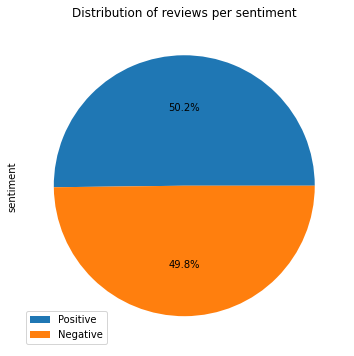

In [26]:
df_imdb['sentiment'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

Since there is only a slight imbalance in the distribution of the data, no measures need to be taken to make sure the classes are divided evenly during the splitting of the data.

### Wordcloud
Next, we generate two wordclouds: one, for the positive reviews, and the other, for the negative reviews.

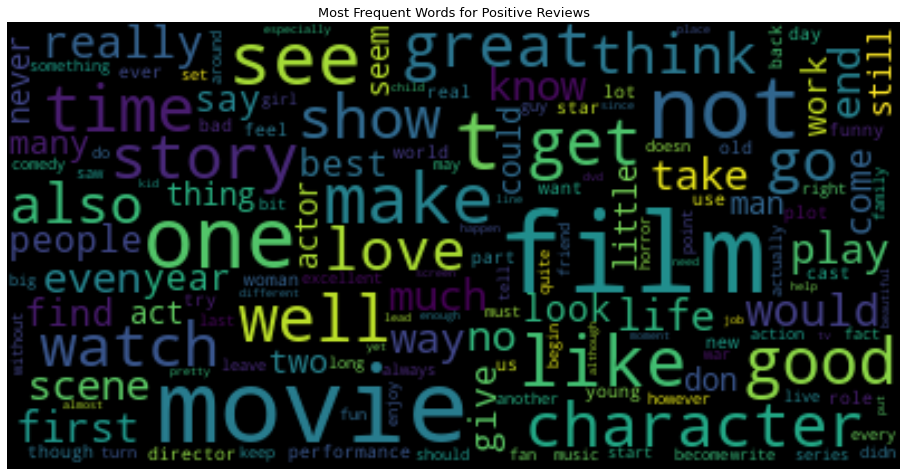

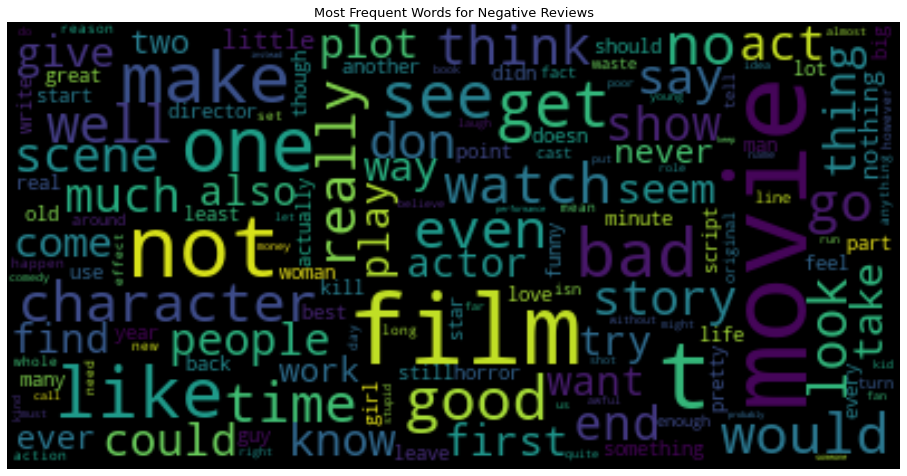

In [27]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data, title):
  wc = WordCloud(max_words=150, max_font_size=50).generate_from_frequencies(data)
  plt.figure(figsize=(16,13))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()

# Generating word cloud for positive reviews
positive_reviews = df_imdb.loc[df_imdb['sentiment'] == 'positive', 'review']
pos_freq = positive_reviews.str.split(expand=True).stack().value_counts()
generate_wordcloud(pos_freq, "Most Frequent Words for Positive Reviews")

# Generating word cloud for negative reviews
negative_reviews = df_imdb.loc[df_imdb['sentiment'] == 'negative', 'review']
neg_freq = negative_reviews.str.split(expand=True).stack().value_counts()
generate_wordcloud(neg_freq, "Most Frequent Words for Negative Reviews")

Word clouds are designed in such a way that the higher the frequency of a word is to appear in a review, the bigger it is shown in the photo. Since these are word clouds on movie reviews, it is natural for the words movie and film to be some of the most frequently used words.

It is interesting to note that the words "no", "not" (including the "t"), "like", and "good" appear frequently for both positive and negative reviews. On the other hand, words with a higher polarity such as "love", "great", and "bad" appear frequently only for their corresponding polarities, that is, "love" and "great" only appear frequently for highly positive reviews and "bad" only appears frequently for highly negative reviews. Thus, it is likely for the model to use these two words as determinants.

## Data Preprocessing
Now that we have sufficiently cleaned and explore the data, we will proceed with further data preprocessing. First, we will encode the labels. Next, since the dataset is very large, we will reduce the size for modelling. Finally, we will split the reduced dataset into the train and test sets.

### Encoding the Labels
To encode the labels, we will be using scikit's `LabelEncoder`. We have already imported the necessary `prepocessing` package earlier so we will be calling it in the next block and fitting the labels.

In [24]:
label_enc = preprocessing.LabelEncoder()
label_enc.fit(df_imdb["sentiment"])

LabelEncoder()

We then transform the list to match the numerical code mapping.

In [25]:
label_enc.transform(df_imdb["sentiment"])

array([1, 1, 1, ..., 0, 0, 0])

We view the mappings using the code below.

In [27]:
print("Original labels:", label_enc.classes_, "\n")
print("Mapping from nominal to numerical labels:")
print(dict(zip(label_enc.classes_,label_enc.transform(label_enc.classes_))))

Original labels: ['negative' 'positive'] 

Mapping from nominal to numerical labels:
{'negative': 0, 'positive': 1}


From above, we see that `negative` labels have been mapped to `0` and `positive` labels have been mapped to `1`. Now that we have the numerical encoding and mapping, we change the `sentiment` column to its numerical mapping.

In [26]:
df_imdb["sentiment"] = label_enc.transform(df_imdb["sentiment"])

We view the results below.

In [29]:
df_imdb.head()

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


### Splitting the Dataset
After the labels have been encoded, we then split the dataset into train and test sets, with 75% of the dataset alloted for training (and validation) and 25% alloted for testing. We also set `random_state` to `42`.

In [27]:
X = df_imdb.drop("sentiment", axis=1)
y = df_imdb["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print("Data distribution:\n- Train: {} \n- Test: {}".format(len(y_train),len(y_test)))

Data distribution:
- Train: 37186 
- Test: 12396


## Sentiment Analysis and Random Forest Classifiers
Random Forest Classifiers are often used for regression and classification tasks. It involves the creation of multiple decision trees on various subsets of given data. Each tree is then used to predict the final output, and the average of these votes is used to determine the prediction. Since RFCs are made up of multiple decision trees, this suggests that the classification involves a series of rules in order to make its prediction.

The dataset, on the other hand, reveals that there are two (2) classifications to each review. This suggests that we will be needing a `supervised` learning algorithm to learn how to classify unlabeled data. 

With all this in mind, we will be using this technique to determine the sentiment of a review. While other techniques such as Naive Bayes can also be utilized for this problem, it is worth noting that Naive Bayes carries the assumption of the distribution of the training dataset to the production data. In addition, it also assumes that each feature is independent of one another. These impose a problem because these are not often the case in real-life situations. 

### Training in Batches
Due to the large size of the dataset and the memory limits, the model will instead be trained in batches. We will be temporarily setting a max batch size of 30 so that the amount of data it is handling at a given moment is not too large.
Initially, we had trained and tested the model for only a portion of the dataset, specifically, 10% of it, because this was what the original author of the dataset had done in his sample notebook. The resulting model had scored highly at around `85% accuracy`; however, since it only used 10% of the dataset, it may not have performed well for the other 90% of the dataset. Thus, we wanted to find a way to use the entire dataset and what we ended up doing was dividing the data into batches and using these batches to train the individual trees of the `RandomForestClassifier`.

In [34]:
max_batch_size = 30
batch = int(np.ceil(y_train.shape[0] / max_batch_size))

print(batch, max_batch_size)

1240 30


Since we will be training in batches, we get the list of terms in `X_train` to make the vectorizer have a consistent set of input words. This is important because different reviews are made up of different words, which means that, after vectorization, they would have different shapes. If the input size for the next step of training is different from the original, the classifier would raise an error.

In [28]:
terms = X_train.review.str.split(expand=True).stack().unique()
words = {v:k for k, v in enumerate(terms)}
print(len(terms))

79850


We apply this list of words to the vectorizer so that the vectorization would have a consistent shape.

In [36]:
vectorizer = TfidfVectorizer(vocabulary=words)

We then create a random forest classifier and set `n_estimators` to `1` to train the current batch of data with only 1 tree. We also set `warm_start` to `True` so that the previous fit is retained as the succeeding batches are trained. Since we will be using a list of words, we set `max_features` to `None` so that the classifier will not remove words that are deemed unnecessary at each training step because doing so would cause problems again in fitting.

In [37]:
rfc = RandomForestClassifier(warm_start = True, n_estimators = 1, max_features=None)

Before we begin training in batches, we shuffle the dataset.

In [38]:
temp = pd.concat([X_train, y_train], axis = 1)
randomized_train = temp.sample(frac = 1, random_state = 42)

X_train = randomized_train.drop("sentiment", axis=1)
y_train = randomized_train["sentiment"]

print(X_train.shape, y_train.shape)

(37186, 1) (37186,)


We create a compute accuracy function to compute the prediction accuracy after  training each batch.

In [39]:
def compute_accuracy(predictions, actual):
  return np.sum(predictions == actual)/actual.shape[0] * 100

Then, we train the `RandomForestClassifier` by batch and increase the number of estimators with each step. Due to the size of the dataset, this part takes around `30 minutes`.

In [40]:
for k in range(batch):
  # compute batch range
  start = max_batch_size * k
  end = start + max_batch_size

  # take sample 
  sub_X = X_train.iloc[start:end]
  sub_y = y_train.iloc[start:end]

  # vectorize the dataset
  tfidf_fit = vectorizer.fit(sub_X['review'])
  tfidf_fit_transform = tfidf_fit.transform(sub_X['review'])
  features = tfidf_fit.get_feature_names_out()
  X_tfidf = pd.DataFrame(tfidf_fit_transform.toarray())
  X_tfidf.columns = features
  
  # fit the dataset
  rfc.fit(X_tfidf, sub_y)
  rfc.n_estimators += 1

  # predict and check accuracy 
  predictions = rfc.predict(X_tfidf)
  print("Batch", k + 1, "of", batch, "Batch accuracy: ", compute_accuracy(predictions, sub_y), "%")

Batch 1 of 1240 Batch accuracy:  73.33333333333333 %
Batch 2 of 1240 Batch accuracy:  90.0 %
Batch 3 of 1240 Batch accuracy:  76.66666666666667 %
Batch 4 of 1240 Batch accuracy:  83.33333333333334 %
Batch 5 of 1240 Batch accuracy:  63.33333333333333 %
Batch 6 of 1240 Batch accuracy:  66.66666666666666 %
Batch 7 of 1240 Batch accuracy:  73.33333333333333 %
Batch 8 of 1240 Batch accuracy:  56.666666666666664 %
Batch 9 of 1240 Batch accuracy:  70.0 %
Batch 10 of 1240 Batch accuracy:  73.33333333333333 %
Batch 11 of 1240 Batch accuracy:  73.33333333333333 %
Batch 12 of 1240 Batch accuracy:  66.66666666666666 %
Batch 13 of 1240 Batch accuracy:  80.0 %
Batch 14 of 1240 Batch accuracy:  56.666666666666664 %
Batch 15 of 1240 Batch accuracy:  50.0 %
Batch 16 of 1240 Batch accuracy:  73.33333333333333 %
Batch 17 of 1240 Batch accuracy:  63.33333333333333 %
Batch 18 of 1240 Batch accuracy:  50.0 %
Batch 19 of 1240 Batch accuracy:  70.0 %
Batch 20 of 1240 Batch accuracy:  53.333333333333336 %
Batc

Batch 164 of 1240 Batch accuracy:  76.66666666666667 %
Batch 165 of 1240 Batch accuracy:  73.33333333333333 %
Batch 166 of 1240 Batch accuracy:  70.0 %
Batch 167 of 1240 Batch accuracy:  70.0 %
Batch 168 of 1240 Batch accuracy:  66.66666666666666 %
Batch 169 of 1240 Batch accuracy:  76.66666666666667 %
Batch 170 of 1240 Batch accuracy:  70.0 %
Batch 171 of 1240 Batch accuracy:  73.33333333333333 %
Batch 172 of 1240 Batch accuracy:  80.0 %
Batch 173 of 1240 Batch accuracy:  70.0 %
Batch 174 of 1240 Batch accuracy:  86.66666666666667 %
Batch 175 of 1240 Batch accuracy:  56.666666666666664 %
Batch 176 of 1240 Batch accuracy:  83.33333333333334 %
Batch 177 of 1240 Batch accuracy:  86.66666666666667 %
Batch 178 of 1240 Batch accuracy:  80.0 %
Batch 179 of 1240 Batch accuracy:  63.33333333333333 %
Batch 180 of 1240 Batch accuracy:  76.66666666666667 %
Batch 181 of 1240 Batch accuracy:  70.0 %
Batch 182 of 1240 Batch accuracy:  86.66666666666667 %
Batch 183 of 1240 Batch accuracy:  90.0 %
Bat

Batch 326 of 1240 Batch accuracy:  66.66666666666666 %
Batch 327 of 1240 Batch accuracy:  73.33333333333333 %
Batch 328 of 1240 Batch accuracy:  76.66666666666667 %
Batch 329 of 1240 Batch accuracy:  76.66666666666667 %
Batch 330 of 1240 Batch accuracy:  70.0 %
Batch 331 of 1240 Batch accuracy:  60.0 %
Batch 332 of 1240 Batch accuracy:  80.0 %
Batch 333 of 1240 Batch accuracy:  60.0 %
Batch 334 of 1240 Batch accuracy:  83.33333333333334 %
Batch 335 of 1240 Batch accuracy:  70.0 %
Batch 336 of 1240 Batch accuracy:  73.33333333333333 %
Batch 337 of 1240 Batch accuracy:  80.0 %
Batch 338 of 1240 Batch accuracy:  66.66666666666666 %
Batch 339 of 1240 Batch accuracy:  80.0 %
Batch 340 of 1240 Batch accuracy:  63.33333333333333 %
Batch 341 of 1240 Batch accuracy:  73.33333333333333 %
Batch 342 of 1240 Batch accuracy:  73.33333333333333 %
Batch 343 of 1240 Batch accuracy:  70.0 %
Batch 344 of 1240 Batch accuracy:  70.0 %
Batch 345 of 1240 Batch accuracy:  63.33333333333333 %
Batch 346 of 1240

Batch 488 of 1240 Batch accuracy:  76.66666666666667 %
Batch 489 of 1240 Batch accuracy:  86.66666666666667 %
Batch 490 of 1240 Batch accuracy:  76.66666666666667 %
Batch 491 of 1240 Batch accuracy:  73.33333333333333 %
Batch 492 of 1240 Batch accuracy:  63.33333333333333 %
Batch 493 of 1240 Batch accuracy:  60.0 %
Batch 494 of 1240 Batch accuracy:  80.0 %
Batch 495 of 1240 Batch accuracy:  80.0 %
Batch 496 of 1240 Batch accuracy:  66.66666666666666 %
Batch 497 of 1240 Batch accuracy:  70.0 %
Batch 498 of 1240 Batch accuracy:  80.0 %
Batch 499 of 1240 Batch accuracy:  73.33333333333333 %
Batch 500 of 1240 Batch accuracy:  93.33333333333333 %
Batch 501 of 1240 Batch accuracy:  73.33333333333333 %
Batch 502 of 1240 Batch accuracy:  63.33333333333333 %
Batch 503 of 1240 Batch accuracy:  86.66666666666667 %
Batch 504 of 1240 Batch accuracy:  80.0 %
Batch 505 of 1240 Batch accuracy:  56.666666666666664 %
Batch 506 of 1240 Batch accuracy:  73.33333333333333 %
Batch 507 of 1240 Batch accuracy

Batch 652 of 1240 Batch accuracy:  86.66666666666667 %
Batch 653 of 1240 Batch accuracy:  76.66666666666667 %
Batch 654 of 1240 Batch accuracy:  73.33333333333333 %
Batch 655 of 1240 Batch accuracy:  80.0 %
Batch 656 of 1240 Batch accuracy:  70.0 %
Batch 657 of 1240 Batch accuracy:  80.0 %
Batch 658 of 1240 Batch accuracy:  63.33333333333333 %
Batch 659 of 1240 Batch accuracy:  80.0 %
Batch 660 of 1240 Batch accuracy:  70.0 %
Batch 661 of 1240 Batch accuracy:  76.66666666666667 %
Batch 662 of 1240 Batch accuracy:  73.33333333333333 %
Batch 663 of 1240 Batch accuracy:  83.33333333333334 %
Batch 664 of 1240 Batch accuracy:  76.66666666666667 %
Batch 665 of 1240 Batch accuracy:  73.33333333333333 %
Batch 666 of 1240 Batch accuracy:  66.66666666666666 %
Batch 667 of 1240 Batch accuracy:  76.66666666666667 %
Batch 668 of 1240 Batch accuracy:  73.33333333333333 %
Batch 669 of 1240 Batch accuracy:  73.33333333333333 %
Batch 670 of 1240 Batch accuracy:  73.33333333333333 %
Batch 671 of 1240 Ba

Batch 814 of 1240 Batch accuracy:  70.0 %
Batch 815 of 1240 Batch accuracy:  63.33333333333333 %
Batch 816 of 1240 Batch accuracy:  50.0 %
Batch 817 of 1240 Batch accuracy:  76.66666666666667 %
Batch 818 of 1240 Batch accuracy:  70.0 %
Batch 819 of 1240 Batch accuracy:  73.33333333333333 %
Batch 820 of 1240 Batch accuracy:  63.33333333333333 %
Batch 821 of 1240 Batch accuracy:  63.33333333333333 %
Batch 822 of 1240 Batch accuracy:  76.66666666666667 %
Batch 823 of 1240 Batch accuracy:  66.66666666666666 %
Batch 824 of 1240 Batch accuracy:  86.66666666666667 %
Batch 825 of 1240 Batch accuracy:  70.0 %
Batch 826 of 1240 Batch accuracy:  63.33333333333333 %
Batch 827 of 1240 Batch accuracy:  66.66666666666666 %
Batch 828 of 1240 Batch accuracy:  73.33333333333333 %
Batch 829 of 1240 Batch accuracy:  80.0 %
Batch 830 of 1240 Batch accuracy:  76.66666666666667 %
Batch 831 of 1240 Batch accuracy:  83.33333333333334 %
Batch 832 of 1240 Batch accuracy:  80.0 %
Batch 833 of 1240 Batch accuracy:

Batch 977 of 1240 Batch accuracy:  80.0 %
Batch 978 of 1240 Batch accuracy:  76.66666666666667 %
Batch 979 of 1240 Batch accuracy:  70.0 %
Batch 980 of 1240 Batch accuracy:  76.66666666666667 %
Batch 981 of 1240 Batch accuracy:  73.33333333333333 %
Batch 982 of 1240 Batch accuracy:  80.0 %
Batch 983 of 1240 Batch accuracy:  86.66666666666667 %
Batch 984 of 1240 Batch accuracy:  80.0 %
Batch 985 of 1240 Batch accuracy:  66.66666666666666 %
Batch 986 of 1240 Batch accuracy:  70.0 %
Batch 987 of 1240 Batch accuracy:  70.0 %
Batch 988 of 1240 Batch accuracy:  73.33333333333333 %
Batch 989 of 1240 Batch accuracy:  70.0 %
Batch 990 of 1240 Batch accuracy:  73.33333333333333 %
Batch 991 of 1240 Batch accuracy:  66.66666666666666 %
Batch 992 of 1240 Batch accuracy:  66.66666666666666 %
Batch 993 of 1240 Batch accuracy:  80.0 %
Batch 994 of 1240 Batch accuracy:  63.33333333333333 %
Batch 995 of 1240 Batch accuracy:  66.66666666666666 %
Batch 996 of 1240 Batch accuracy:  60.0 %
Batch 997 of 1240

Batch 1136 of 1240 Batch accuracy:  76.66666666666667 %
Batch 1137 of 1240 Batch accuracy:  66.66666666666666 %
Batch 1138 of 1240 Batch accuracy:  63.33333333333333 %
Batch 1139 of 1240 Batch accuracy:  76.66666666666667 %
Batch 1140 of 1240 Batch accuracy:  83.33333333333334 %
Batch 1141 of 1240 Batch accuracy:  83.33333333333334 %
Batch 1142 of 1240 Batch accuracy:  66.66666666666666 %
Batch 1143 of 1240 Batch accuracy:  76.66666666666667 %
Batch 1144 of 1240 Batch accuracy:  66.66666666666666 %
Batch 1145 of 1240 Batch accuracy:  63.33333333333333 %
Batch 1146 of 1240 Batch accuracy:  83.33333333333334 %
Batch 1147 of 1240 Batch accuracy:  70.0 %
Batch 1148 of 1240 Batch accuracy:  66.66666666666666 %
Batch 1149 of 1240 Batch accuracy:  73.33333333333333 %
Batch 1150 of 1240 Batch accuracy:  66.66666666666666 %
Batch 1151 of 1240 Batch accuracy:  80.0 %
Batch 1152 of 1240 Batch accuracy:  83.33333333333334 %
Batch 1153 of 1240 Batch accuracy:  73.33333333333333 %
Batch 1154 of 1240

For the final batch training, when all the estimators have been created, we have achieved `81.25% training accuracy`. Although there are less chances of overfitting, we will still determine whether there is a better combination of hyperparameters and batch size to train the model.

### Hyperparameter Tuning
The two (2) most common methods for hyperparemeter tuning are: GridSearchCV and RandomizedSearchCV. The first method uses all possible permutations of the dataset, where as the latter collects randomized samples. Due to the size of the dataset, we will be using a variation of the latter.

Thus, we have selected the following choices for each of the following parameters:
- `batch_size`: 10, 30, 50, 100, 200
- `criterion`:  `gini` or `entropy`
- `max_depth`: 5, 10, 20, 30
- `min_samples_split`: 2, 4, 6, 10, 15, 20
- `max_leaf_nodes`: 3, 5, 10, 20, 50, 100

In [43]:
hyperparameters = {
    'batch_size': [10, 30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, 30],
    'max_leaf_nodes': [3, 5, 10, 20, 50, 100],
    'min_samples_split': [2, 4, 6, 10, 15, 20]
}

We create a function for batch training.


In [29]:
def batch_train(clf, X, y, batch_size):
  # initialize variables
  batch = int(np.ceil(y.shape[0] / batch_size))
  vectorizer = TfidfVectorizer(vocabulary=words)

  for k in range(batch):
    # compute batch range
    start = batch_size * k
    end = start + batch_size

    # take sample 
    sub_X = X.iloc[start:end]
    sub_y = y.iloc[start:end]

    # vectorize the dataset
    tfidf_fit = vectorizer.fit(sub_X['review'])
    tfidf_fit_transform = tfidf_fit.transform(sub_X['review'])
    features = tfidf_fit.get_feature_names_out()
    X_tfidf = pd.DataFrame(tfidf_fit_transform.toarray())
    X_tfidf.columns = features
    
    # fit the dataset
    clf.fit(X_tfidf, sub_y)
    clf.n_estimators += 1

  return clf

We also create a function for testing. Again, this will be done in batches. The accuracy of the entire test set will be returned after the testing.

In [30]:
def batch_test(clf, X, y):
  batch_size = 200
  batch = int(np.ceil(y.shape[0] / batch_size))
  correct = 0
  vectorizer = TfidfVectorizer(vocabulary=words)

  for k in range(batch):
    # compute batch range
    start = batch_size * k
    end = start + batch_size

    # take sample 
    sub_X = X.iloc[start:end]
    sub_y = y.iloc[start:end]

    # vectorize the dataset
    tfidf_fit = vectorizer.fit(sub_X['review'])
    tfidf_fit_transform = tfidf_fit.transform(sub_X['review'])
    features = tfidf_fit.get_feature_names_out()
    X_tfidf = pd.DataFrame(tfidf_fit_transform.toarray())
    X_tfidf.columns = features
    
    # predict the dataset
    predictions = clf.predict(X_tfidf)
    correct += np.sum(predictions == sub_y)
    
  return correct / y.shape[0] * 100

Next, we create a function for cross validation that accepts the hyperparameters listed earlier. This step is crucial in order to provide the opportunity to learn on multiple combinations of data to prevent overfitting. Since our dataset is already large enough, we will only have two folds for cross validation.

In [41]:
def crossval(X1, y1, X2, y2, batch_size, criterion, max_depth, max_leaf_nodes, min_samples_split):
  # initialize RandomForestClassifier
  clf1 = RandomForestClassifier(n_estimators = 1, 
                               criterion = criterion, 
                               max_depth = max_depth, 
                               max_leaf_nodes = max_leaf_nodes, 
                               min_samples_split = min_samples_split, 
                               warm_start = True, 
                               max_features=None)

  # FOLD 1
  # batch train
  rfc1 = batch_train(clf1, X1, y1, batch_size)

  # validation
  accuracy = batch_test(rfc1, X2, y2) / 2

  # initialize RandomForestClassifier
  clf2 = RandomForestClassifier(n_estimators = 1, 
                               criterion = criterion, 
                               max_depth = max_depth, 
                               max_leaf_nodes = max_leaf_nodes, 
                               min_samples_split = min_samples_split, 
                               warm_start = True, 
                               max_features=None)

  # FOLD 2
  # batch train
  rfc2 = batch_train(clf2, X2, y2, batch_size)

  # validation
  accuracy += batch_test(rfc2, X1, y1) / 2

  print(batch_size, criterion, max_depth, max_leaf_nodes, min_samples_split)
  print("Average accuracy:", accuracy, "%")

Finally, we split the dataset into two folds and maintain these folds as we perform cross validation. We run cross validation 10 times with a random set of hyperparameters. This takes approximately `5 hours` to run.

In [44]:
n_iter = 10
np.random.seed(42)

n_batch = len(hyperparameters['batch_size'])
n_criterion = len(hyperparameters['criterion'])
n_depth = len(hyperparameters['max_depth'])
n_leaf = len(hyperparameters['max_leaf_nodes'])
n_split = len(hyperparameters['min_samples_split'])

# split dataset into two folds
X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size = 0.5, random_state=42)

for _ in range(n_iter):
  # generate random values
  random = np.random.randint(0, n_batch)
  batch_size = hyperparameters['batch_size'][random]
  random = np.random.randint(0, n_criterion)
  criterion = hyperparameters['criterion'][random]
  random = np.random.randint(0, n_depth)
  max_depth = hyperparameters['max_depth'][random]
  random = np.random.randint(0, n_leaf)
  max_leaf_nodes = hyperparameters['max_leaf_nodes'][random]
  random = np.random.randint(0, n_split)
  min_samples_split = hyperparameters['min_samples_split'][random]

  crossval(X1, y1, X2, y2, batch_size, criterion, max_depth, max_leaf_nodes, min_samples_split)

100 gini 20 10 15
Average accuracy: 70.95950088743075 %
10 entropy 5 10 10
Average accuracy: 49.84940569031356 %
30 entropy 30 3 2
Average accuracy: 68.12510084440382 %
200 entropy 5 20 15
Average accuracy: 71.65062120152746 %
100 gini 30 10 20
Average accuracy: 71.33060829344377 %
200 entropy 10 100 2
Average accuracy: 72.8688215995267 %
200 entropy 10 5 10
Average accuracy: 70.13392136825686 %
30 gini 20 50 2
Average accuracy: 69.61221965255743 %
200 entropy 10 10 6
Average accuracy: 72.54343032323993 %
10 gini 20 50 10
Average accuracy: 49.84940569031356 %


The results can be better visualized using the table below:

| Batch Size | Criterion | max_depth | max_leaf_nodes | min_samples_split | Accuracy (%) |
|------------|-----------|-----------|----------------|-------------------|--------------|
| 100        | gini      | 20        | 10             | 15                | 70.959       |
| 10         | entropy   | 5         | 10             | 10                | 49.849       |
| 30         | entropy   | 30        | 3              | 2                 | 68.125       |
| 200        | entropy   | 5         | 20             | 15                | 71.650       |
| 100        | gini      | 30        | 10             | 20                | 71.330       |
| 200        | entropy   | 10        | 100            | 2                 | 72.868       |
| 200        | entropy   | 10        | 5              | 10                | 70.139       |
| 30         | gini      | 20        | 50             | 2                 | 69.612       |
| 200        | entropy   | 10        | 10             | 6                 | 72.543       |
| 10         | gini      | 20        | 50             | 10                | 49.849       |

From above, we can see that the model with the best score is approximately `72.87%`. Thus, we retrain the model with the following hyperparameters:
- `batch_size`: 200
- `criterion`:  `entropy`
- `max_depth`: 10
- `max_leaf_nodes`: 100
- `min_samples_split`: 2

Since the hyperparameters are being sampled randomly without replacement, there is still a low possibility for certain combinations to repeat. After testing it multiple times, there were times when there were two instances of the same set of hyperparameters, with one of them performing slightly better than the other. This result may have occurred because the classifier had picked a different random feature when splitting.


### Testing

Since we have retrieved the best hyperparameters, we now instantiate a Random Forest Classifier with the best hyperparameters and perform batch training. This section runs for about `10 minutes`.

In [34]:
# initialize parameters
batch_size = 200
criterion = 'entropy'
max_depth = 10
max_leaf_nodes = 100
min_samples_split = 2

# initialize model
rfc = RandomForestClassifier(n_estimators = 1, 
                               criterion = criterion, 
                               max_depth = max_depth, 
                               max_leaf_nodes = max_leaf_nodes, 
                               min_samples_split = min_samples_split, 
                               warm_start = True, 
                               max_features = None)

# train
trained_model = batch_train(rfc, X_train, y_train, batch_size)

We then get the predictions on our test set and calculate the accuracy. 

In [35]:
accuracy = batch_test(trained_model, X_test, y_test)

In [36]:
print(accuracy)

72.57986447241046


All in all, our model has achieved a test accuracy of `~72.58%`.

## Benchmarking


### TextBlob
TextBlob is a library that specializes in processing text data. When used in the context of sentiment analysis, it returns two (2) properties given an input:
- `polarity`: an indicator whether the sentiment is positve or negative [-1,1]
- `subjectivity`: determines how heavily the input is influenced by emotion [0,1]

For this step, we will focus more on a review's polarity. TextBlob no longer needs training, thus we will proceed directly to testing.

First, we retrieve the preprocessed test data from earlier.

In [50]:
X_test_tb = pd.DataFrame(X_test)
y_test_tb = pd.DataFrame(y_test)
df_tb = pd.concat([X_test, y_test_tb], axis=1, ignore_index=True)
df_tb.rename({0: 'review', 1: 'sentiment'}, axis=1, inplace=True)
df_tb

,review,sentiment
29171,soul plane horrible attempt comedy should appe...,0
43589,guest future tell fascinate story time travel ...,1
38712,national treasure thoroughly misguide hodge po...,0
16045,ok first say want check whether movie average ...,0
5248,haven t always fan show grow t season start se...,1
...,...,...
37298,comedy like almost every line every character ...,1
38043,possible spoilersno one likely pick dvd red du...,1
29283,film basically poor take old urban legend baby...,0
41905,water show plight indian widow late say end pr...,0


Next, we create a new column to store the polarity score of a given review.

In [51]:
df_tb['text_blob_polarity'] = df_tb['review'].apply(lambda x: TextBlob(x).polarity)

Since our original labels only has two classifications, we label the review as `positive` if it has received a polarity greater than 0. Otherwise, we label it as `negative`. It is worth noting that our labels have been encoded earlier, thus such changes will also be applied here.

In [52]:
df_tb['text_blob_label'] = [1 if x>0 else 0 for x in df_tb['text_blob_polarity']]

In [53]:
df_tb

,review,sentiment,text_blob_polarity,text_blob_label
29171,soul plane horrible attempt comedy should appe...,0,-0.028778,0
43589,guest future tell fascinate story time travel ...,1,0.202597,1
38712,national treasure thoroughly misguide hodge po...,0,0.171364,1
16045,ok first say want check whether movie average ...,0,0.012939,1
5248,haven t always fan show grow t season start se...,1,0.073743,1
...,...,...,...,...
37298,comedy like almost every line every character ...,1,0.119850,1
38043,possible spoilersno one likely pick dvd red du...,1,0.051786,1
29283,film basically poor take old urban legend baby...,0,-0.086944,0
41905,water show plight indian widow late say end pr...,0,0.238737,1


We then compute for the accuracy.

In [54]:
original_y = df_tb['sentiment']
predicted_y = df_tb['text_blob_label']
textblob_accuracy = compute_accuracy(original_y, predicted_y)
print(textblob_accuracy )

70.12746047111972


Overall, TextBlob has achieved an accuracy of `70.12%` using the same test set.

### VADER (Valence Aware Dictionary and Sentiment Reasoner) 
Similar to TextBlob, VADER is also a python library that specializes in processing text data for sentiment analysis. It is a lexical and rule-based tool that is mainly used in analyzing social media content. The library returns three (3) properties given an input:

- `positive`: The probability that an input is of positive nature
- `negative`: The probability that an input is of negative nature
- `neutral`: The probability that an input is of neutral nature
- `compound`: The normalized sum of the positive, negative, and neutral score of an input. It ranges between -1, and 1, with 1 being considered as the most positive context.

It is important to note that VADER no longer needs training, thus we will proceed directly to testing.

To proceed with VADER testing, we first retrieve the processed test data from earlier.

In [55]:
X_test_vad = pd.DataFrame(X_test)
y_test_vad = pd.DataFrame(y_test)
df_vad = pd.concat([X_test, y_test_tb], axis=1, ignore_index=True)
df_vad.rename({0: 'review', 1: 'sentiment'}, axis=1, inplace=True)
df_vad

,review,sentiment
29171,soul plane horrible attempt comedy should appe...,0
43589,guest future tell fascinate story time travel ...,1
38712,national treasure thoroughly misguide hodge po...,0
16045,ok first say want check whether movie average ...,0
5248,haven t always fan show grow t season start se...,1
...,...,...
37298,comedy like almost every line every character ...,1
38043,possible spoilersno one likely pick dvd red du...,1
29283,film basically poor take old urban legend baby...,0
41905,water show plight indian widow late say end pr...,0


Next, we initiate a sentiment intensity analyzer.

In [56]:
sid = SentimentIntensityAnalyzer()

We then create a new column to store the scores of a given review.

In [57]:
df_vad['vader_scores'] = df_vad['review'].apply(lambda x: sid.polarity_scores(x))

In [58]:
df_vad

,review,sentiment,vader_scores
29171,soul plane horrible attempt comedy should appe...,0,"{'neg': 0.197, 'neu': 0.649, 'pos': 0.153, 'co..."
43589,guest future tell fascinate story time travel ...,1,"{'neg': 0.128, 'neu': 0.59, 'pos': 0.281, 'com..."
38712,national treasure thoroughly misguide hodge po...,0,"{'neg': 0.084, 'neu': 0.658, 'pos': 0.258, 'co..."
16045,ok first say want check whether movie average ...,0,"{'neg': 0.169, 'neu': 0.609, 'pos': 0.222, 'co..."
5248,haven t always fan show grow t season start se...,1,"{'neg': 0.095, 'neu': 0.672, 'pos': 0.233, 'co..."
...,...,...,...
37298,comedy like almost every line every character ...,1,"{'neg': 0.214, 'neu': 0.555, 'pos': 0.232, 'co..."
38043,possible spoilersno one likely pick dvd red du...,1,"{'neg': 0.195, 'neu': 0.657, 'pos': 0.148, 'co..."
29283,film basically poor take old urban legend baby...,0,"{'neg': 0.255, 'neu': 0.664, 'pos': 0.081, 'co..."
41905,water show plight indian widow late say end pr...,0,"{'neg': 0.167, 'neu': 0.687, 'pos': 0.146, 'co..."


Finally, we convert the compound scores to its corresponding label, with 1 corresponding to a positive sentiment, and 0 otherwise.

In [59]:
df_vad['vader_compound'] = df_vad['vader_scores'].apply(lambda x: x.get('compound'))
df_vad['vader_label'] = [1 if x>0 else 0 for x in df_vad['vader_compound']]
df_vad

,review,sentiment,vader_scores,vader_compound,vader_label
29171,soul plane horrible attempt comedy should appe...,0,"{'neg': 0.197, 'neu': 0.649, 'pos': 0.153, 'co...",-0.7682,0
43589,guest future tell fascinate story time travel ...,1,"{'neg': 0.128, 'neu': 0.59, 'pos': 0.281, 'com...",0.9833,1
38712,national treasure thoroughly misguide hodge po...,0,"{'neg': 0.084, 'neu': 0.658, 'pos': 0.258, 'co...",0.9971,1
16045,ok first say want check whether movie average ...,0,"{'neg': 0.169, 'neu': 0.609, 'pos': 0.222, 'co...",0.9280,1
5248,haven t always fan show grow t season start se...,1,"{'neg': 0.095, 'neu': 0.672, 'pos': 0.233, 'co...",0.9959,1
...,...,...,...,...,...
37298,comedy like almost every line every character ...,1,"{'neg': 0.214, 'neu': 0.555, 'pos': 0.232, 'co...",0.4284,1
38043,possible spoilersno one likely pick dvd red du...,1,"{'neg': 0.195, 'neu': 0.657, 'pos': 0.148, 'co...",-0.9217,0
29283,film basically poor take old urban legend baby...,0,"{'neg': 0.255, 'neu': 0.664, 'pos': 0.081, 'co...",-0.9517,0
41905,water show plight indian widow late say end pr...,0,"{'neg': 0.167, 'neu': 0.687, 'pos': 0.146, 'co...",-0.5116,0


In [60]:
original_y = df_vad['sentiment']
predicted_y = df_vad['vader_label']
vader_accuracy = compute_accuracy(original_y, predicted_y)
print(vader_accuracy )

68.0622781542433


With this, VADER has achieved an accuracy of `68.06%` using the same test set.

## Insights and Conclusion
Comparing the accuracy of our model with TextBlob and VADER, we can see that it performs comparably with all 3 models being within roughly 5% of each other. One thing of note is that among the compared estimators, VADER is the only one that classifies neutral sentiment as opposed to RFC and TextBlob which only classify positive and negative sentiments. This means that the comparison is not exactly apples-to-apples and is something that needs to be kept in mind when looking at the numbers. 

Our model performs the best at `72.58%` accuracy. However, a concern that we have with our current pipeline is the splitting performed during batch training. As it is done randomly, we have no guarantee that the distribution of data for each batch follows the distribution of the original data set which may affect the model's performance. It is possible for certain batches to contain only positive or only negative reviews. Moreover, certain batches contain similar frequencies of positive and negative words but have different labels which might confuse the model such as in these sentences:
- There is not a single good thing. (negative)
- Nothing else is as good as this. (positive)
- There is nothing good about this movie. (negative)

For these cases, relying on the contexts of the words may be better.

With more time and resources, using a variation of `GridSearchCV` instead for hyperparameter tuning may also lead to better results since simply choosing randomly could cause certain combinations of hyperparameters to repeat.